In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numba import jit
from functools import reduce
from operator import add
import transforms3d as t3d
from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from  matplotlib import colors
%matplotlib inline

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x18d3538fda0>)

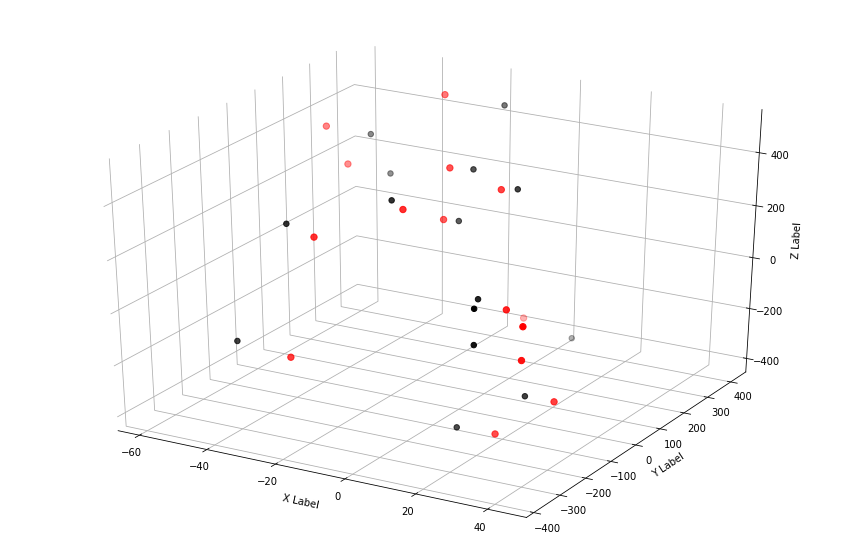

In [2]:
class surrogate(object):
    def __init__(self, epsilon, noise=0.1, init_pop = 15, options={}):
        self._epsilon = epsilon
        self._columns = ["z", "y", "z"]
        self._prev_suffix = "_"
        self._particle_pos_noise = (0.01,0.005) if "particle_pos_noise" not in options else options["particle_pos_noise"]
        self._last = None
        self._data = None
        self._exp_hash = None
        self._init_pop = init_pop
        #todo - create a fake point that we move around with the transform representing the structure origin
        #IF this is properly translated then it acts as the center of the structure and new objects should be created with respect to this in append points
        self._origin = np.array([0,0,0])
        
    def _append_points(self, add_n, inliers= []):
        n = len(inliers) + add_n
        low_bounds_zyx, up_bounds_zyx = [-50, -500, -500],    [50, 500, 500]
        
        upt = lambda : np.array( [  np.random.uniform(low_bounds_zyx[i], up_bounds_zyx[i]) for i in range(3) ])
        
        def _near_any_(p,v):
            """enforce min separation"""
            for p_ in v:
                if distance.euclidean(p,p_) <= self._epsilon: return True
            return False
        
        while len(inliers) < n:
            pt = upt()
            while _near_any_(pt, inliers): pt = upt()
            inliers.append(pt)

        return np.array(inliers)
    
    def random_transform(npa, max_t=0, com =np.array([0,0,0])):
        def _translate_(npa, vec):
            Tr = np.eye(4)
            Tr[:3,-1] = vec
            padder = lambda A :  np.matrix(np.hstack((A,np.ones((len(A),1)))))
            return np.array(np.dot(padder(npa),Tr.T)[:,:-1])
        #we take random small rotations on all axes
        angles = [np.random.uniform(-np.pi/24,np.pi/24) for i in range(3)]
        #translate to the origin
        _npa = _translate_(npa, -1* com)
        #get a random rotation marix and apply it
        _npa = np.dot(npa, t3d.euler.euler2mat(*angles))
        #triangle rule: random translation plus return from origin to where it was and add random translation
        rvec = np.array([np.random.uniform(0,max_t) for i in range(3)]) + com
        #return the translated tensor
        return _translate_(_npa, rvec)

    def _init_data(self): 
        return self._append_points(self._init_pop)
        
    def _transform(self,data):
        return surrogate.random_transform(data, com = self._origin)
    
    def _process(self):
        """
        manage the ids that are actually accessible in the data - do births deaths and outliers
        #special ids: -1 is new, -2 is outliers, -3/nan is hidden
        #for cube structure for example, override this to manage the life matrix 
        """
        pass
    
    def transform(self, data=None):
        self._last = data if data is not None else self._init_data()
        self._data = self._transform(self._last.copy())
        self._process()
        return self._data
    
    @property
    def tail(self): return self._last, self._data, None
        
    def dump(t, X,  Y, ids, Y_, mfunc, collector=None):
        s = mfunc(ids, Y_)
        #make a dataframe 
        columns = ["x", "y", "z", "x_", "y_", "z_", "t", "marriage_key", "score", "exp_hash"]
        #save_plot_frame_result(df)
        #if collector is not None: collector.append(df)
        
    def plot3d(self, lines = None, cols="k"):
        #before
        last,data,ids = self.tail
        xs,ys,zs = last[:,0], last[:,1], last[:,2]
        #after
        xs_,ys_,zs_ = data[:,0], data[:,1], data[:,2]
        
        fig = plt.figure(figsize=(15,10))#figsize=(15,10)
        ax = fig.add_subplot(111, projection='3d')

        ax.xaxis.pane.fill, ax.yaxis.pane.fill,ax.zaxis.pane.fill = False,False,False
        ax.xaxis.pane.set_edgecolor('w'); ax.yaxis.pane.set_edgecolor('w'); ax.zaxis.pane.set_edgecolor('w')

        #ax.set_ylim(-40,40)
        #ax.set_xlim(-40,40)
        #ax.set_zlim(-40,40)
        
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')

        cmap = colors.ListedColormap(['lightgrey', 'red'])
        boundaries = [-1,1]
        norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

        graph = ax.scatter(xs, ys, zs, c="k", marker='o', cmap='Reds', s=30)
        graph = ax.scatter(xs_, ys_, zs_, c="r", marker='o', cmap='Blues', s=40)

        #if lines is not None: plot_lines(npa,lines,ax)
        return fig, graph, ax
    
    def plot(self, y_ids=None):
        u,v,ids = self.tail
        plt.figure(figsize=(15,4))
        
        #plot main points - make colours on the right if the ids are not -1
        plt.scatter(u[:,1],u[:,2],c='grey')#, marker=markers[k]
        plt.scatter(v[:,1],v[:,2],c='red')
        
        #add marriages between points that have ids
        plt.plot([u[:,1],v[:,1]], [u[:,2],v[:,2]], 'r:')
        
        #add specific marriages for the passed in ids
        
        #add the outliers for the -2 split
    
class cube_surrogate(surrogate):
    def __init__(self, epsilon, noise=0.1, options={}):
        super().__init__(epsilon, noise, options)
        
    #create the life matrix masks
    
    def _process(self):
        super()._process()
        
    @property
    def tail(self): 
        #use the mask here to present a filtered view of the cube
        return self._last, self._data, None
        
    def _init_data(self):
        """
        This is the main guy to override to generate the initial shape of the data
        """
        s, rho = self._epsilon * 15, 10
        
        cube = [[s,-s,-s],[s,-s,s],
                [s, s,-s],[s,s, s],
                [-s,s,-s],[-s,s,s],
                [-s,-s,-s],[-s,-s,s]]
        
        #interpolated points - between each pair, name an axis i.e. 0,1,2 and we need twele pairs - each point joins 3 other points
        lines = { 0: [1, 2, 6], 1: [0,3,7], 2: [0,3,4], 3: [1,2,5], 4: [2,5,6], 5: [3,4,7], 6: [0,4,7] }
        npa = np.array(cube)
        npa = np.array(list(self._interpolate_points_origin(npa, lines, rho)))
        
        return npa
        #return np.vstack([npa,[0,0,0]])
    
    def _interpolate_points_origin(self, pts, lines, density=10):
        for k,v in lines.items():
            p1 = pts[k]
            for ptk in v:
                p2= pts[ptk]
                #because we are using the origin cube and lines only one axis can satisfy below
                axis_to_intrp = np.argmax(np.abs(np.array(p1) - np.array(p2)))
                vals = np.linspace(p2[axis_to_intrp],p1[axis_to_intrp],density)
                for v in vals:
                    p = list(p1)
                    p[axis_to_intrp] = v
                    yield p
                    
sf =  surrogate(30)
#sf =  cube_surrogate(30)
data = sf.transform()
sf.plot3d()

#todo-> properly detail with the concept of center of structure after we try some tracking
#next we should check that the tracker can build constellations and their attributes and build a matrix of gammas to evaluate and transform the data

In [231]:
# data = sf.transform(data)
# sf.plot3d()

In [245]:
#add the tree indexes - maybe nearest neighbours is enough
from scipy.spatial import KDTree as scKDTree
from itertools import combinations

class fuzzy_registration(object):
    def __init__(self, epsilon, use_translations=False,extra_models=[]):
        """
        fuzzy mappers uses only the frame-frame data to generate transformations. 
        More models e.g. state space models can be used to generate transformations - they should be scikitfied and keep their own state
        """
        self._transform = None
        self._transforms = []
        self._data = None
        self.constellation_pairing = "knn"
        self._epsilon = epsilon
        #number of nearest neigbours to check in attribute space
        self._k = 5
        #polygon points for constellation matching
        self._p=3
        #self._ssm = KalmanFilter()
        
    def _solve_affine(self, X,Y):
        pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
        unpad = lambda x: x[:,:-1]
        A, res, rank, s = np.linalg.lstsq(pad(X), pad(Y),rcond=None)
        tr = lambda x: unpad(np.dot(pad(x), A))        
        return tr
    
    ##poly area recipe - to utils
    
    #area of polygon poly
    def _poly_area(self, poly):
        def unit_normal(a, b, c):
            x = np.linalg.det([[1,a[1],a[2]],  [1,b[1],b[2]],  [1,c[1],c[2]]])
            y = np.linalg.det([[a[0],1,a[2]],  [b[0],1,b[2]],  [c[0],1,c[2]]])
            z = np.linalg.det([[a[0],a[1],1],  [b[0],b[1],1],  [c[0],c[1],1]])
            magnitude = (x**2 + y**2 + z**2)**.5
            return (x/magnitude, y/magnitude, z/magnitude)

        if len(poly) < 3: return 0
        total = [0, 0, 0]
        N = len(poly)
        for i in range(N):
            vi1 = poly[i]
            vi2 = poly[(i+1) % N]
            prod = np.cross(vi1, vi2)
            total[0] += prod[0]
            total[1] += prod[1]
            total[2] += prod[2]
        result = np.dot(total, unit_normal(poly[0], poly[1], poly[2]))
        return abs(result/2)
  
    ##################

    #@jit
    def _constellation_maps(self, X, Y):      
        """
        determine constellations and compute transformation between them - pairs are sensible as we min distance in attribute space
        """
        p = self._p
        Gamma = []
        xperms, yperms = list(combinations(range(len(X)),p)), list(combinations(range(len(Y)),p))
        Xpolys, Ypolys= X[xperms], Y[yperms]
        Xattr  = np.array([[ fr._poly_area(p) for p in Xpolys ]]).T
        Yattr =  np.array([[ fr._poly_area(p) for p in Ypolys ]]).T
        
        target = scKDTree(Yattr)
        d,id_ = target.query(Xattr,k=self._k)
        
        for i, key in enumerate(id_.flatten()):
            row = int(i/k)
            Gamma.append(self._solve_affine(Xpolys[row], Ypolys[key]))
            
        return Gamma
    
    def add_priors(self, X, Y):
        #get translations for all points
        #if the _ssm exists, affine from state space
        return []
                        
    def _ngh_distance(self, X, Y):
        """
        distance to nearest neighbour within epsilon
        """
        target = scKDTree(X)
        dist,ids=target.query(Y, k=1,distance_upper_bound=self._epsilon)
        #replace values greater than epsilon with -1     
        dist[np.isnan(dist)] = -1
        dist[np.isinf(dist)] = -1
        
        return dist

    def _eval(self, gamma, X, Y):
        """
        we care about the normed-total transform distances between X->Y and also the total capped distances to the nearest neighbours
        
        returns: if we match nothing the worst score is epsilon * X. Otherwise reg-loss using ball-bounded NN distances and average transform displacement
        """
        Y_ = gamma(X)
        d_yy_, dxy = 0, 0
        matches = 0
        
        YY_d =  self._ngh_distance(X, Y)
        
        for i, v in enumerate(YY_d):
            if v != -1: 
                dxy += distance.euclidean(X[i],Y[i])  
                matches += 1
            d_yy_ += self._epsilon if v == -1 else v
                
        return self._epsilon * len(X) if matches == 0 else dxy/matches + d_yy_
    
    def _find_transforms(self, X,Y):
        """compute transforms/translations"""
        #get possible pairings
        Gamma = self._constellation_maps(X,Y)
        Gamma += self.add_priors(X,Y)
        #evaluate X-Y against the entire dataset using the mapper's objective function
        scored_transforms = [ (gamma, self._eval(gamma, X,Y)) for gamma in Gamma ]
        #sort ascending on the fittest transforms; we returned into transforms a sortable (gamma, score) tuple list
        return [t[0] for t in sorted(scored_transforms, key=lambda x : x[1])]
    
    def fit(self, X, Y):
        self._data = X
        self._transforms = self._find_transforms(X,Y)
        #take the first one of the sorted list if we have a list
        self._transform = self._transforms[0] if len(self._transforms) > 0 else None
        
    def transform(self, X):
        assert self._transform is not None, "you must call fit to create a transform"
        return self._transform(X)
    
    def fit_transform(self, X,Y):
        self.fit(X,Y)
        return self.transform(X)
    
    def predict(self, X, as_ids=True): 
        #this thing needs to know which ids passed the epsilon test
        Y = self.transform(X)
        d= self._ngh_distance(X,Y)
        match = np.array(range(len(d)))
        match[d<0] = np.nan
        if as_ids: return match
        return Y,d
    

In [ ]:
fr = fuzzy_registration(30)
X = data
Y = sf._last

In [ ]:
fr.fit_transform(X,Y)

In [ ]:
fr.predict(X)

In [409]:
def f1_metric(A,B):return None
    
def run_experiment(epsilon = 30, noise = 0.1, init_pop = 20, time_steps = 10):
    fm = fuzzy_registration(epsilon=epsilon)
    sf = surrogate(epsilon=epsilon, noise=noise, init_pop=init_pop)
    data = sf.transform(data)
    results = []
    
    for t in range(time_steps):
        #make the first transition from the initial data
        data = sf.transform(data)
        #take the t-1 and t data
        X,Y,ids = sf.transform.tail
        #fit them and make a prediction
        fm.fit_transform(X,Y)
        Y_ = fm.predict(X)
        #dump all the tracking data somehow
        sf.dump(t, X, Y, ids, Y_, f1_metric, results)
        
    return results

In [46]:
#parameter space over noise and epsilon for some population size
#results = pd.DataFrame(  [run_experiment(*p) for p in [{},{}]] )   